In [785]:
import numpy as np
import pandas as pd
import scipy.special as sp
import matplotlib.pyplot as plt
import scipy.stats as stats
import math
import sys

# 1. Prelude

Binomial law: repeat an experiment $N$ times, counting $n$ the number of times of "success", where the probability for this success is p. 
$$ P(n) = B(n;N,p) = {N\choose k} p^n (1-p)^N-n $$

### 1. Show that the mean is $E(n) = pN$ and that the variance is $V(n) = Np(1-p)$ 

The Binomial distribution is the sum of $N$ independent Bernoulli variables with probability $p$.

For Bernoulli:
$$ <x> = P(0) \cdot 0 + P(1) \cdot 1 = P(1) = p $$
$$ <x^2> = P(0) \cdot 0^2 + P(1) \cdot 1^2 = P(1) = p $$
$$ V[x] = <x^2> - <x>^2 = p - p^2 = p(1-p) $$

Therefore for the Binomial distribution:
$$ E[n] = N<x> = Np $$
$$ V[n] = N V[x] = Np(1-p) $$

### 2. What is the maximum lixelihood estimate $\hat{p}$? What is its variance?

Let's consider $\{s_i, r_i\}$, where $i$ is the experiment, $s_i$ is the number of successes, $r_i$ is the number of failures, such that $r_i + s_i = N_i$.

It follows a Binomial distribution $B(p) = {N\choose s} p^s (1-p)^r $, with $s+r=N$.

The log likelihood function is therefore:
$$ l(p) = \ln(B(p)) = \ln({N\choose s}) + s\ln(p) + r\ln(1-p) $$
To find the maximum of the log likelihood:
$$ 0 = \frac{\partial l(p)}{\partial p} = \frac{s}{p} - \frac{r}{(1-p)} = \frac{s(1-p)-rp}{p(1-p)} = \frac{s(1-p)-rp}{p(1-p)} $$
$$ \Rightarrow s-(s+r)p = 0 \Rightarrow s-Np = 0 $$
$$ \Rightarrow \hat{p} = \frac{s}{N} $$

The variance is readily found:

$$ Var(\hat{p}) = Var(\frac{s}{N}) = \frac{1}{N^2} Var(s) = \frac{Np(1-p)}{N^2} = \frac{p(1-p)}{N} $$

### 3. Propose a simple algorithm for generating $n$ following a Binomial law $B(n;N,p)$ assuming a uniform generator betweeon 0 and 1

The following function implements the idea

In [653]:
def binom_from_unif(n_trials,N,p):
    x = np.zeros(n_trials)
    y = np.random.rand(n_trials,N)
    for trial in np.arange(n_trials):
        for j in np.arange(N):
            if y[trial,j] < p:
                x[trial] = x[trial]+1
    return x

Now I will compare the binomial histogram obtained from my function and the one built in the numpy.random library

It is possible to change n_trials, N, p to see that the distribution are the same for all the possible values.

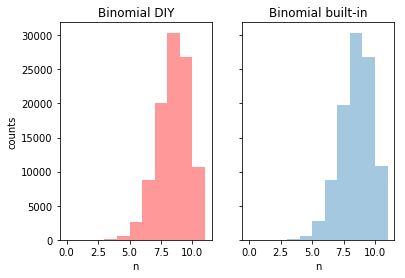

In [684]:

n_trials = 100000
N = 10
p = 0.8

f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
ax1.hist(binom_from_unif(n_trials,N,p),bins=N+1, range=[0,N+1], color='r', alpha=0.4)
ax1.set_title('Binomial DIY')
ax1.set_xlabel('n')
ax1.set_ylabel('counts')
ax2.hist(np.random.binomial(N,p,n_trials), bins=N+1, range=[0,N+1], alpha=0.4)
ax2.set_title('Binomial built-in')
ax2.set_xlabel('n')

plt.show()

### 4. Draw the binomial distribution for $N=10$, $p=0.9$.

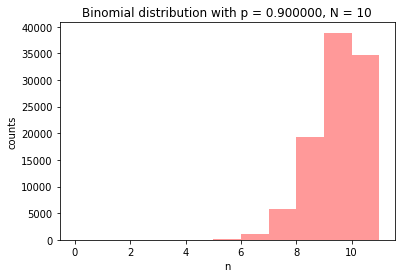

In [685]:
N=10
p=0.9
plt.hist(binom_from_unif(n_trials,N,p),bins=N+1, range=[0,N+1], color='r', alpha=0.4)
plt.xlabel("n")
plt.ylabel("counts")
plt.title("Binomial distribution with p = %f, N = %d" % (p, N))
plt.show()

# 2. Interval estimation

In [554]:
#mean of binomial distribution 
def mean(p, N):
    return p*N

#variance of binomial distribution
def var(p, N):
    return N*p*(1-p)

#standard deviation of p_hat = n/N
def sigma(p, N):
    return np.sqrt(var(p,N))/N                 

#number of sigmas
def Z(CL):
    return np.sqrt(2)*sp.erfinv(CL)



#function needed for clopper pearson algorithm
#since problem is discrete, for the same n will correspond different p
#to minimize the overcoverage (but still overcovering), the highest value for the lower limit
#and the lowest value for the upper limit is chosen.
#this function will return the corresponding value accordingly.
def choose_index(seq,item,default,mode):
    #find indices of item in seq (pandas is useful here)
    seq_series = pd.Series(seq)
    indices = list(seq_series[seq_series == item].index)
    #choose the correct index
    if len(indices) != 0:      
        #minimum overcoverage possible
        if mode == 'min_low': #max lower bound for minimum interval, on the list of upper bounds
            result = int(indices[-1])
        elif mode == 'min_upp': #min upper bound for minimum interval, on the list of lower bounds
            result = int(indices[0])    
        else:
            print("Incorrect mode in function choose_index")
            return
    else:
        return default
    return result




In [725]:

def wald(n, N, CL, verbose=False):
    #make n and N float to prevent errors when dividing
    n = float(n)
    N = float(N)
    #set p_hat, sigma, and z
    p_hat = n/N
    p_sigma = sigma(p_hat,N)
    z = Z(CL)
    #interval constructed with Wald procedure, in gaussian approximation
    lower = p_hat - z*p_sigma
    upper = p_hat + z*p_sigma
    #set 0 and 1 boundaries
    if lower < 0:
        lower = 0
    if upper > 1:
        upper = 1
    interval = [lower,upper]
    if(verbose == True):
        print("Wald confidence interval for p given %d successes in %d experiments is:" % (n, N) )
        print(interval)
    return interval

def wilson(n, N, CL, verbose=False):   
    n = float(n)
    N = float(N)
    p_hat = n/N
    p_sigma = sigma(p_hat,N)
    z = Z(CL)
    step = 0.01
    #initialize the two bounds of the interval to the "central" value
    lower = p_hat
    upper = p_hat
    #decrease the lower bound and increase the upper bound in steps given the Wilson condition
    while(lower + z*sigma(lower,N) >= p_hat):
        lower-=step
    while(p_hat >= upper - z*sigma(upper,N)):
        upper+=step
    #set 0 and 1 boundaries
    if lower < 0:
        lower = 0
    if upper > 1:
        upper = 1
    #when procedure has come to an end, this is the final interval
    interval = [lower, upper]
    if(verbose == True):
        print("Wilson confidence interval for p given %d successes in %d experiments is:" % (n, N) )
        print(interval)
    return interval

def agresticoull(n,N,CL,verbose=False):
    n = float(n)
    N = float(N)
    z = Z(CL)

    int_wilson = wilson(n,N,CL)
    #find midpoint of wilson interval
    p_midpoint_wilson = (int_wilson[0]+int_wilson[1])/2
    #find sigma of the midpoint
    p_sigma = sigma(p_midpoint_wilson,N) 
    #wald interval given wilson midpoint and sigma
    lower = p_midpoint_wilson - z*p_sigma
    upper = p_midpoint_wilson + z*p_sigma
    #set 0 and 1 boundaries
    if lower < 0:
        lower = 0
    if upper > 1:
        upper = 1
    interval = [lower, upper]  
    if(verbose == True):
        print("Agresti-Coull confidence interval for p given %d successes in %d experiments is:" % (n, N) )
        print(interval)
    return interval

#function that builds a confidence belt for the clopper pearson method
def cp_confidencebelt(N, CL, step=0.001, plotting=False):
    p_list = np.linspace(0,1,int(1/step))
    alpha = 1 - CL
    lowers = []
    uppers = []
    for p in p_list:
        #find lower bound, starting from left, if not found: nan
        k = 0
        while(stats.binom.cdf(k,N,p) <= alpha/2 and k <= N):
            k += 1
        if(k!=0):
            lowers.append(k-1)
        else:
            lowers.append(float("NaN"))
        #find upper bound, starting from right, if not found: nan
        k = N
        while((1-(stats.binom.cdf(k-1,N,p))) <= alpha/2 and k >=0):
            k -= 1
        if(k!=N):
            uppers.append(k+1)
        else:
            uppers.append(float("NaN"))
    
    if plotting==True:
        #plot confidence belt
        plt.figure(figsize = (10,7))
        plt.plot(lowers, p_list, marker='*', markersize=3, linewidth=1, label="lowers")
        plt.plot(uppers, p_list, marker='*', markersize=3, linewidth=1, label="uppers")
        plt.xlabel("n")
        plt.ylabel("p")
        plt.title("N = " + str(N) + ", CL = " + str(CL))
        plt.show()
        
    return lowers, uppers
    
def clopperpearson(n,N,CL,lowers=[],uppers=[],step=0.001,verbose=False):
    alpha = 1 - CL
    p_list = np.linspace(0,1,int(1/step))
    
    if (len(lowers) == len(uppers) == 0):
        # build horizontally confidence belt
        lowers, uppers = cp_confidencebelt(N,CL,step)
    #just checking
    else:
        #in case the lowers and uppers are already given, no need to build the confidence belt
        if (not(len(lowers) == len(uppers) == len(p_list))):
            print("Error in clopper pearson function, sizes of lowers, uppers, and p_list are different")
            return

    # read vertically (the previous lower bound will become upper bound, and viceversa)
    index_UB = choose_index(lowers, n, default=len(p_list)-1, mode='min_upp')
    index_LB = choose_index(uppers, n, default=0, mode='min_low')
    
    #final interval
    interval = [p_list[index_LB],p_list[index_UB]]
    
    if(verbose==True):
        print("Clopper-Pearson confidence interval (with Build Horiz. Read Vert.) for p given %d successes in %d experiments is:" % (n, N) )
        print(interval)
    return interval


#cheating: use the beta function
#found at https://gist.github.com/DavidWalz/8538435
#using it to check my algorithm
def clopper_pearson(n,N,CL):
    """
    http://en.wikipedia.org/wiki/Binomial_proportion_confidence_interval
    alpha confidence intervals for a binomial distribution of k expected successes on n trials
    Clopper Pearson intervals are a conservative estimate.
    """
    alpha = 1-CL
    lo = stats.beta.ppf(alpha/2, n, N-n+1)
    hi = stats.beta.ppf(1 - alpha/2, n+1, N-n)
    return lo, hi

In [726]:
N = 10
n = 6
CL = 0.6827
z = Z(CL)
step = 0.001

wald(n, N, CL, verbose=True)
wilson(n,N,CL, verbose=True)
agresticoull(n,N,CL, verbose=True)

lowers, uppers = cp_confidencebelt(N, CL, step)
clopperpearson(n,N,CL,lowers,uppers,step=step,verbose=True)
#cheating
print("Cheating Clopper-Pearson" , list(clopper_pearson(n,N,CL)))



Wald confidence interval for p given 6 successes in 10 experiments is:
[0.44507730233816867, 0.7549226976618313]
Wilson confidence interval for p given 6 successes in 10 experiments is:
[0.43999999999999984, 0.7400000000000001]
Agresti-Coull confidence interval for p given 6 successes in 10 experiments is:
[0.43446527557496517, 0.7455347244250348]
Clopper-Pearson confidence interval (with Build Horiz. Read Vert.) for p given 6 successes in 10 experiments is:
[0.39539539539539537, 0.7807807807807807]
Cheating Clopper-Pearson [0.39539991686900117, 0.7800118624296924]


All the values are correct (my algorithm matches the cheating one), except for the values n=0, n=N.
In my function, the lower bound in the case n=0 is 0, and the upper bound in the case n=N is 1, while in the beta function those bounds are "nan".

### Confidence belt for Clopper Pearson method


Following is the confidence belt for the Clopper Pearson method for $N=10$ and step size in $p$ of $0.01$, for $CL=0.6827$.

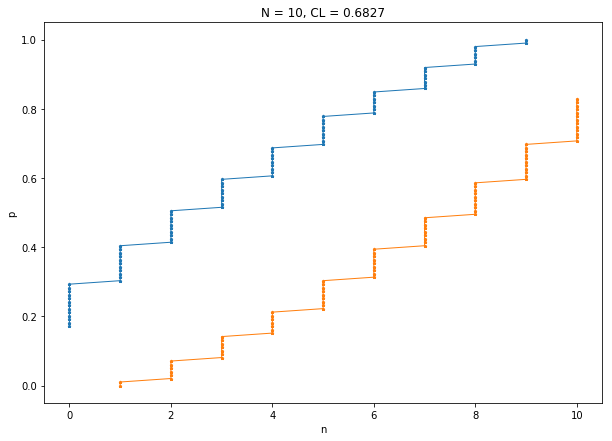

In [592]:
lowers, uppers = cp_confidencebelt(N=10, CL=0.6827, step=0.01, plotting=True)

In order to compare with the scientific literature, I have also plotted the confidence belt for $CL=0.95$.
It matches with Figure 1 in the article at  http://www.bios.unc.edu/~mhudgens/bios/662/2008fall/Backup/clopper.pdf 

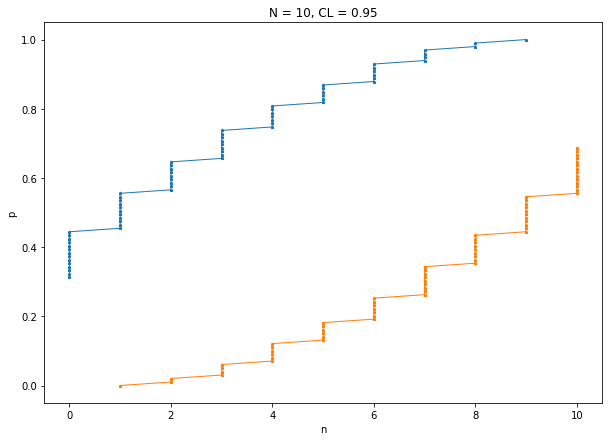

In [651]:
#compare with http://www.bios.unc.edu/~mhudgens/bios/662/2008fall/Backup/clopper.pdf figure 1
lowers, uppers = cp_confidencebelt(N=10, CL=0.95, step=0.01, plotting=True)

### 2.1 Compare the intervals on p from the above methods, in the following cases

- $N=10$, $n=10$
- $N=10$, $n=9$
- $N=10$, $n=5$
- $N=100$, $n=90$

/home/pipsini/Programs/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in sqrt
  # This is added back by InteractiveShellApp.init_path()


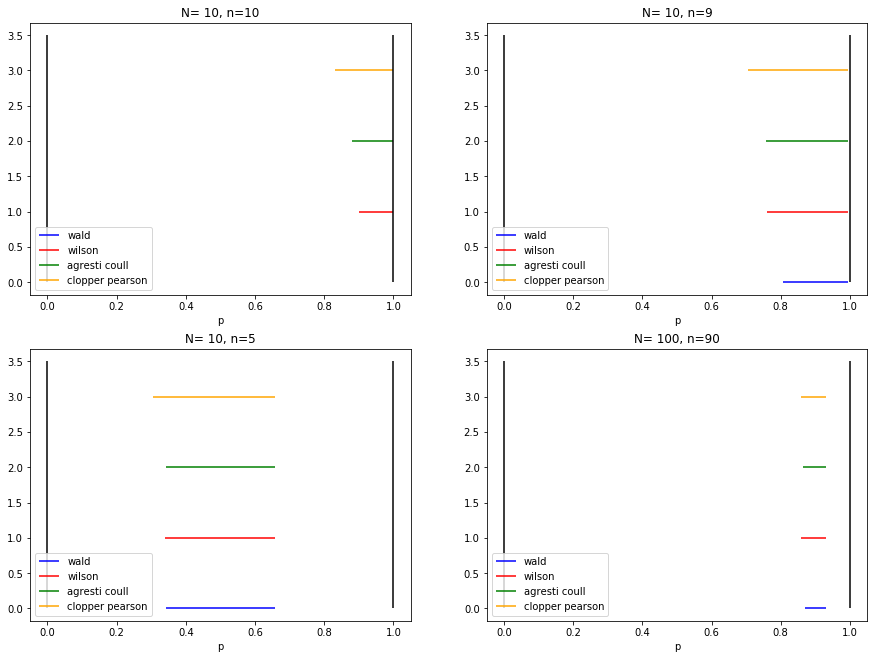

In [764]:

CL = 0.6827
step = 0.001

plt.figure(figsize=(15,11))

plt.subplot(221)
N = 10
n = 10
plt.hlines(y=0, xmin =  wald(n, N, CL)[0], xmax =  wald(n, N, CL)[1], color='b', label='wald')
plt.hlines(y=1, xmin =  wilson(n, N, CL)[0], xmax =  wald(n, N, CL)[1], color='r', label='wilson')
plt.hlines(y=2, xmin =  agresticoull(n, N, CL)[0], xmax =  wald(n, N, CL)[1], color='g', label='agresti coull')
plt.hlines(y=3, xmin =  clopperpearson(n, N, CL)[0], xmax =  wald(n, N, CL)[1], color='orange', label='clopper pearson')
plt.vlines(x=1, ymin = 0, ymax = 3.5)
plt.vlines(x=0, ymin = 0, ymax = 3.5)
plt.title("N= %d, n=%d" %(N,n))
plt.xlabel('p')
plt.legend(loc='lower left')

plt.subplot(222)
N = 10
n = 9
plt.hlines(y=0, xmin =  wald(n, N, CL)[0], xmax =  wald(n, N, CL)[1], color='b', label='wald')
plt.hlines(y=1, xmin =  wilson(n, N, CL)[0], xmax =  wald(n, N, CL)[1], color='r', label='wilson')
plt.hlines(y=2, xmin =  agresticoull(n, N, CL)[0], xmax =  wald(n, N, CL)[1], color='g', label='agresti coull')
plt.hlines(y=3, xmin =  clopperpearson(n, N, CL)[0], xmax =  wald(n, N, CL)[1], color='orange', label='clopper pearson')
plt.vlines(x=1, ymin = 0, ymax = 3.5)
plt.vlines(x=0, ymin = 0, ymax = 3.5)
plt.title("N= %d, n=%d" %(N,n))
plt.xlabel('p')
plt.legend(loc='lower left')

plt.subplot(223)
N = 10
n = 5
plt.hlines(y=0, xmin =  wald(n, N, CL)[0], xmax =  wald(n, N, CL)[1], color='b', label='wald')
plt.hlines(y=1, xmin =  wilson(n, N, CL)[0], xmax =  wald(n, N, CL)[1], color='r', label='wilson')
plt.hlines(y=2, xmin =  agresticoull(n, N, CL)[0], xmax =  wald(n, N, CL)[1], color='g', label='agresti coull')
plt.hlines(y=3, xmin =  clopperpearson(n, N, CL)[0], xmax =  wald(n, N, CL)[1], color='orange', label='clopper pearson')
plt.vlines(x=1, ymin = 0, ymax = 3.5)
plt.vlines(x=0, ymin = 0, ymax = 3.5)
plt.title("N= %d, n=%d" %(N,n))
plt.xlabel('p')
plt.legend(loc='lower left')

plt.subplot(224)
N = 100
n = 90
plt.hlines(y=0, xmin =  wald(n, N, CL)[0], xmax =  wald(n, N, CL)[1], color='b', label='wald')
plt.hlines(y=1, xmin =  wilson(n, N, CL)[0], xmax =  wald(n, N, CL)[1], color='r', label='wilson')
plt.hlines(y=2, xmin =  agresticoull(n, N, CL)[0], xmax =  wald(n, N, CL)[1], color='g', label='agresti coull')
plt.hlines(y=3, xmin =  clopperpearson(n, N, CL)[0], xmax =  wald(n, N, CL)[1], color='orange', label='clopper pearson')
plt.vlines(x=1, ymin = 0, ymax = 3.5)
plt.vlines(x=0, ymin = 0, ymax = 3.5)
plt.title("N= %d, n=%d" %(N,n))
plt.xlabel('p')
plt.legend(loc='lower left')



plt.show()

The Clopper pearson interval is always the largest.
This is because it is built in a conservative way, always overcovering.

Overall, the intervals are very similar to each other, for fixed $N$ and $n$.

### Additional plots

Fixing $N$, I want to plot the confidence intervals for all the prossible $n$, from $0$ to $N$.

First, I want to check whether the Clopper-Pearson is correct again, and to do so I will compare my result with the figure 3 of the paper http://www.bios.unc.edu/~mhudgens/bios/662/2008fall/Backup/clopper.pdf .
Here, $N=30$ and $CL=0.95$ is used. I will also compare my result with the "cheating" function.

Then I want to plot the confidence intervals for the 4 different methods, for $N=10$, $CL=0.6827$.

In [778]:
#prepare empty lists for the upper and lower limits for the three intervals
lower_wald = []
upper_wald = []
lower_wilson = []
upper_wilson = []
lower_agresticoull = []
upper_agresticoull = []
lower_clopperpearson = []
upper_clopperpearson = []
lower_clopperpearson_cheat = []
upper_clopperpearson_cheat = []

#CL = 0.6827
#N = 10

CL = 0.95
N = 30

#n can range from 0 to N included
n_range = range(0,N+1)

for n in n_range:
    #wald limits
    lower_wald.append(wald(n,N,CL)[0])
    upper_wald.append(wald(n,N,CL)[1])
    #wilson limits
    lower_wilson.append(wilson(n,N,CL)[0])
    upper_wilson.append(wilson(n,N,CL)[1])
    #agresti and coull limits
    lower_agresticoull.append(agresticoull(n,N,CL)[0])
    upper_agresticoull.append(agresticoull(n,N,CL)[1])
    #clopper-pearson limits
    lower_clopperpearson.append(clopperpearson(n,N,CL)[0])
    upper_clopperpearson.append(clopperpearson(n,N,CL)[1])
    #clopper-pearson limits cheating
    lower_clopperpearson_cheat.append(clopper_pearson(n,N,CL)[0])
    upper_clopperpearson_cheat.append(clopper_pearson(n,N,CL)[1])


/home/pipsini/Programs/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in sqrt
  # This is added back by InteractiveShellApp.init_path()


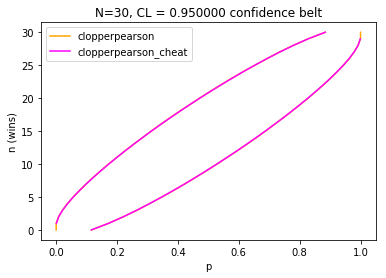

In [779]:
#N = 30, CL = 0.95 http://www.bios.unc.edu/~mhudgens/bios/662/2008fall/Backup/clopper.pdf compare with figure 3

#plot confidence intervals
plt.plot(lower_clopperpearson,n_range,label="clopperpearson", color='orange')
plt.plot(upper_clopperpearson,n_range, color='orange')
plt.plot(lower_clopperpearson_cheat,n_range,label="clopperpearson_cheat", color='fuchsia')
plt.plot(upper_clopperpearson_cheat,n_range, color='fuchsia')

plt.ylabel("n (wins)")
plt.xlabel("p")
plt.title("N=%d, CL = %f confidence belt"% (n,CL))
plt.legend(loc='best')



My algorithm gives the same result as the "cheating" one, the only difference is that the values $0$ and $N$ are included in mine as lower and upper bound respectively, as anticipated before. 

Also, the result is the same as figure 3 of the article cited before.

Therefore, I will procede in plotting all the different methods, for $N=10$ and $CL=0.6827$ (change values and re-run the cell that finds the interval)

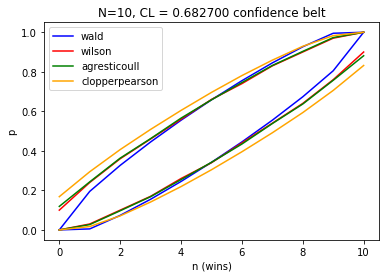

In [776]:
#plot confidence intervals
plt.plot(n_range,lower_wald,label="wald", color='b')
plt.plot(n_range,upper_wald, color='b')
plt.plot(n_range,lower_wilson,label="wilson", color='r')
plt.plot(n_range,upper_wilson, color='r')
plt.plot(n_range,lower_agresticoull,label="agresticoull", color='g')
plt.plot(n_range,upper_agresticoull, color='g')
plt.plot(n_range,lower_clopperpearson,label="clopperpearson", color='orange')
plt.plot(n_range,upper_clopperpearson, color='orange')


plt.xlabel("n (wins)")
plt.ylabel("p")
plt.title("N=%d, CL = %f confidence belt"% (n,CL))
plt.legend(loc='best')


As expected, the clopper pearson method is the most conservative. Wald is the least.

# 3. Study of frequentist coverage properties of various types of interval

We study $68.27\%$ $CL$ in three ways:

### 1. Set $N=10$ and check coverage as a function of $p$, for $0 \le p \le 1$.

In [783]:
CL = 0.6827
step=0.001
N = 10
N_trials = 1000


#function that outputs the fraction of values included in interval, for 1000 trials
#ideally it should be approx = CL
def fraction_in_interval(p,N,N_trials,step=step):

    n_incl_wald = 0
    n_incl_wilson = 0
    n_incl_ac = 0
    n_incl_cp = 0
    n_incl_cp_cheat = 0        

    n = np.random.binomial(N,p, size=N_trials)
    
    #build confidence belt for clopper pearson
    lowers_cp, uppers_cp = cp_confidencebelt(N, CL, step)
    
    #check if p is included in interval
    for number in n:

        waldint = wald(number, N, CL)
        if(waldint[0] <= p <= waldint[1]):
            n_incl_wald+=1

        wilsonint = wilson(number, N, CL)
        if(wilsonint[0] <= p <= wilsonint[1]):
            n_incl_wilson+=1

        agresticoullint = agresticoull(number, N, CL)
        if(agresticoullint[0] <= p <= agresticoullint[1]):
            n_incl_ac+=1   

        clopperpearsonint = clopperpearson(number,N,CL,lowers_cp,uppers_cp,step=step)   
        if(clopperpearsonint[0] <= p <= clopperpearsonint[1]):
            n_incl_cp+=1
            
        clopperpearsonint_cheat = clopper_pearson(number,N,CL) 
        if(clopperpearsonint_cheat[0] <= p <= clopperpearsonint_cheat[1]):
            n_incl_cp_cheat+=1
            

    return([float(n_incl_wald)/float(N_trials), float(n_incl_wilson)/float(N_trials), float(n_incl_ac)/float(N_trials), float(n_incl_cp)/float(N_trials), float(n_incl_cp_cheat)/float(N_trials)])

In [788]:
wald_fractions = []
wilson_fractions = []
ac_fractions = []
cp_fractions = []
#cp_fractions_cheat = []

p_list = np.linspace(0,1,101)

#fixed N, varying p
for p in p_list:
    sys.stdout.write("\rp = %f" %p)
    sys.stdout.flush()
    fractions = fraction_in_interval(p,N,N_trials)
    wald_fractions.append(fractions[0])
    wilson_fractions.append(fractions[1])
    ac_fractions.append(fractions[2])
    cp_fractions.append(fractions[3])
    #cp_fractions_cheat.append(fractions[4])


p = 0.000000

/home/pipsini/Programs/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in sqrt
  # This is added back by InteractiveShellApp.init_path()


p = 1.000000

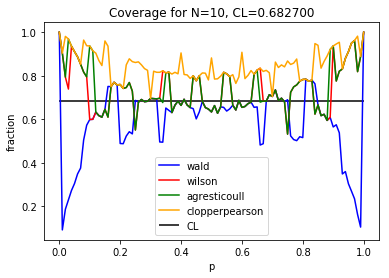

In [790]:
#plot
#CL 0.68

#compare with plot http://dx.doi.org/10.1080/00031305.1998.10480550 figure 4
plt.plot(p_list, wald_fractions, label="wald",color='b')
plt.plot(p_list, wilson_fractions, label="wilson",color='r')
plt.plot(p_list, ac_fractions, label="agresticoull",color='g')
plt.plot(p_list, cp_fractions, label="clopperpearson",color='orange')
#plt.plot(p_list, cp_fractions_cheat, label="clopperpearson_cheat",color='fuchsia')
plt.hlines(CL,0,1,label="CL",color='black')
plt.xlabel("p")
plt.ylabel("fraction")
plt.title("Coverage for N=%d, CL=%f"%(N,CL))

plt.legend(loc='best')

This plot matches well with the similar result in the Figure 4 of the paper  http://dx.doi.org/10.1080/00031305.1998.10480550 

The Clopper Pearson is again clearly conservative, while the Wald interval is not.

### 2. Make a 2D plot of coverage as function of $p$ and $N$, for $0\le p \le 1$ and $2 \le N \le 20$

In [801]:
N_trials = 1000

wald_fr_all = []
wilson_fr_all = []
ac_fr_all = []
cp_fr_all = []

CL = 0.95
#CL = 0.6827
N_initial = 2
#N_final = 20
N_final = 50

p_list = np.linspace(0,1,11)

#vary N, vary p

for N in range(N_initial,N_final+1):
     
    wald_fractions = []
    wilson_fractions = []
    ac_fractions = []
    cp_fractions = []
    #cp_fractions_cheat = []
    
    for p in p_list:
        sys.stdout.write("\rN = %d, p = %f" %(N,p))
        sys.stdout.flush()
        fractions = fraction_in_interval(p,N,N_trials)
        wald_fractions.append(fractions[0])
        wilson_fractions.append(fractions[1])
        ac_fractions.append(fractions[2])
        cp_fractions.append(fractions[3])
        #cp_fractions_cheat.append(fractions[4])
    
    #stack all fractions data for each interal method, for each N and for each p 
    if(N == N_initial):
        wald_fr_all = wald_fractions
        wilson_fr_all = wilson_fractions
        ac_fr_all = ac_fractions
        cp_fr_all = cp_fractions
        #cp_fr_all_cheat = cp_fractions_cheat
    else:
        wald_fr_all = np.vstack((wald_fr_all,wald_fractions))
        wilson_fr_all = np.vstack((wilson_fr_all,wilson_fractions))
        ac_fr_all = np.vstack((ac_fr_all,ac_fractions))
        cp_fr_all = np.vstack((cp_fr_all,cp_fractions))
        #cp_fr_all_cheat = np.vstack((cp_fr_all_cheat,cp_fractions_cheat))

N = 2, p = 0.000000

/home/pipsini/Programs/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in sqrt
  # This is added back by InteractiveShellApp.init_path()


N = 50, p = 1.000000

In [802]:
#shape the data in a more usable way for the 2d plots

wald_data = [[],[],[]]
wilson_data = [[],[],[]]
ac_data = [[],[],[]]
cp_data = [[],[],[]]
#cp_data_cheat = [[],[],[]]

n_Ns = N_final-N_initial+1
n_ps = len(p_list)

for N1 in range(n_Ns):
    for p1 in range(n_ps):
        wald_data[0].append(float(p1)/10.)
        wald_data[1].append(N1+2)
        wald_data[2].append(wald_fr_all[N1][p1])
        
        wilson_data[0].append(float(p1)/10.)
        wilson_data[1].append(N1+2)
        wilson_data[2].append(wilson_fr_all[N1][p1])
        
        ac_data[0].append(float(p1)/10.)
        ac_data[1].append(N1+2)
        ac_data[2].append(ac_fr_all[N1][p1])
        
        cp_data[0].append(float(p1)/10.)
        cp_data[1].append(N1+2)
        cp_data[2].append(cp_fr_all[N1][p1])  
        
        #cp_data_cheat[0].append(float(p1)/10.)
        #cp_data_cheat[1].append(N1+2)
        #cp_data_cheat[2].append(cp_fr_all_cheat[N1][p1]) 

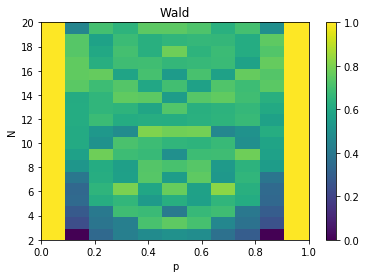

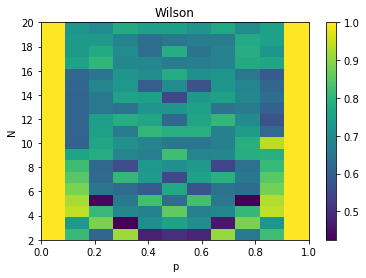

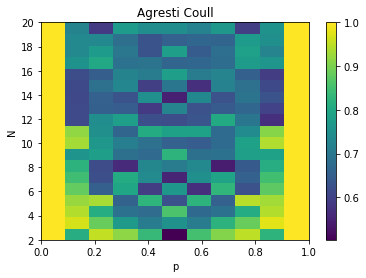

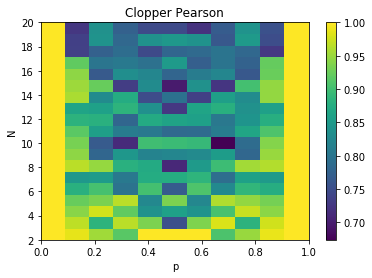

In [794]:
#2d plots 

plt.hist2d(wald_data[0],wald_data[1],weights=wald_data[2],bins=[11,19])
plt.colorbar()
plt.xlabel("p")
plt.ylabel("N")
plt.title("Wald")
plt.show()

plt.hist2d(wilson_data[0],wilson_data[1],weights=wilson_data[2],bins=[11,19])
plt.colorbar()
plt.xlabel("p")
plt.ylabel("N")
plt.title("Wilson")
plt.show()

plt.hist2d(ac_data[0],ac_data[1],weights=ac_data[2],bins=[11,19])
plt.colorbar()
plt.xlabel("p")
plt.ylabel("N")
plt.title("Agresti Coull")
plt.show()

plt.hist2d(cp_data[0],cp_data[1],weights=cp_data[2],bins=[11,19])
plt.colorbar()
plt.xlabel("p")
plt.ylabel("N")
plt.title("Clopper Pearson")
plt.show()

# plt.hist2d(cp_data_cheat[0],cp_data_cheat[1],weights=cp_data_cheat[2],bins=[11,19])
# plt.colorbar()
# plt.xlabel("p")
# plt.ylabel("N")
# plt.title("Clopper Pearson cheat")
# plt.show()

### 3. Average the previous plot over all values of $p$, to get the average coverage as a function of $N$.

I will do this for $N$ that ranges from 2 to 50, and for the two different values of $CL$, $0.6827$ and $0.95$.

For $CL = 0.95$, I wanted to compare the plot with Figure 5 of the paper  http://dx.doi.org/10.1080/00031305.1998.10480550 .

In [805]:
#average as function of N

wald_av = []
wilson_av = []
ac_av = []
cp_av = []
cp_av_cheat = []

Nrange = range(N_initial,N_final+1)
npdata = len(p_list)

for N1 in Nrange:
    N1 = N1-2
    #arrays of coverage values for every p between 0 and 1 for given N
    wald_n_set = (wald_data[2])[(N1*npdata):((N1+1)*npdata)] 
    wilson_n_set = (wilson_data[2])[(N1*npdata):((N1+1)*npdata)]
    ac_n_set = (ac_data[2])[(N1*npdata):((N1+1)*npdata)]
    cp_n_set = (cp_data[2])[(N1*npdata):((N1+1)*npdata)]
    cp_n_set_cheat = (cp_data_cheat[2])[(N1*npdata):((N1+1)*npdata)]
    #find average coverage value
    wald_av.append(np.average(wald_n_set))
    wilson_av.append(np.average(wilson_n_set))
    ac_av.append(np.average(ac_n_set))
    cp_av.append(np.average(cp_n_set))
    cp_av_cheat.append(np.average(cp_n_set_cheat))


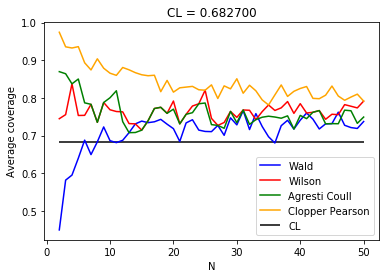

In [800]:
#68% confidence level 

plt.plot(Nrange,wald_av, label="Wald", color='b')
plt.plot(Nrange,wilson_av, label="Wilson", color='r')
plt.plot(Nrange,ac_av, label="Agresti Coull", color='g')
plt.plot(Nrange,cp_av, label="Clopper Pearson", color='orange')
#plt.plot(Nrange,cp_av_cheat, label="Clopper Pearson cheat", color='fuchsia')
plt.hlines(CL,Nrange[0],Nrange[-1], label="CL")
plt.legend()
plt.xlabel("N")
plt.ylabel("Average coverage")
plt.title("CL = %f"%(CL))
plt.show()

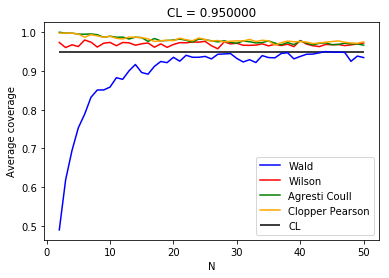

In [806]:
#95% confidence level 
#compare with  http://dx.doi.org/10.1080/00031305.1998.10480550 figure 5

plt.plot(Nrange,wald_av, label="Wald", color='b')
plt.plot(Nrange,wilson_av, label="Wilson", color='r')
plt.plot(Nrange,ac_av, label="Agresti Coull", color='g')
plt.plot(Nrange,cp_av, label="Clopper Pearson", color='orange')
#plt.plot(Nrange,cp_av_cheat, label="Clopper Pearson cheat", color='fuchsia')
plt.hlines(CL,Nrange[0],Nrange[-1], label="CL")
plt.legend()
plt.xlabel("N")
plt.ylabel("Average coverage")
plt.title("CL = %f"%CL)
plt.show()

First of all, we can see that the $95\%$ $CL$ plot matches with Figure 5 of the paper by Agresti 1998.
The Wald interval approaches the $CL$ from below, while the others from above. The Clopper Pearson is generally the most conservative again. All the different methods approach the $CL$ as $N$ increases.

For the $68\%$ $CL$, the Wald averages are also greater than the $CL$, but the relative trend (between the different methods) is analogous to the $95\%$ $CL$.

# References



[1] Alan Agresti & Brent A. Coull (1998) Approximate is Better than “Exact”
for Interval Estimation of Binomial Proportions, The American Statistician, 52:2, 119-126, DOI:
10.1080/00031305.1998.10480550

[2] Clopper, C. J., and Pearson, E. S. (1934), "The Use of Confidence or
Fiducial Limits Illustrated in the Case of the Binomial," Biometrika, 26,
404-413.